In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints
import utils

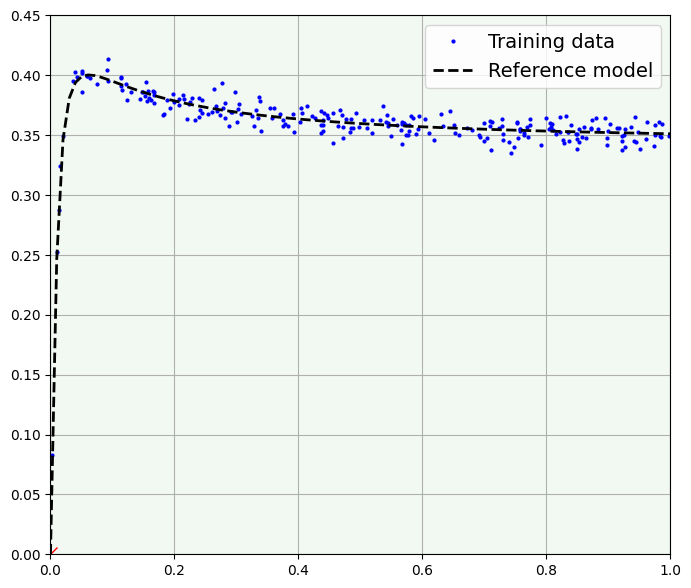

In [2]:
S = dataset.ABSDataset()
S.sample(size=250, noise=0.03, mesh=False)
#S.load('../data/magman.csv')
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * (B(x) ^ 1)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_k_mse = None
best_r2 = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_k_mse
    global best_r2
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_r2, __best_k_mse = jump_backprop.jump_backprop(stree, stree_pr, synth_unkn_models, S, max_rounds=10)
    hist_set.append(hist)

    if best_k_mse is None or __best_k_mse < best_k_mse or (__best_k_mse == best_k_mse and __best_r2 > best_r2):
        best_unkn_models = __best_unkn_models
        best_k_mse = __best_k_mse
        best_r2 = __best_r2

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

--- ASP Model ---
sign_unkn("A","-",0,1) sign_unkn("A","-",1,2) sign_unkn("A","-",1,1) sign_unkn("B","-",0,1) sign_unkn("B","-",1,2) sign_unkn("B","-",1,1) sign_unkn("A'","-",0,1) sign_unkn("A'","-",1,2) sign_unkn("A'","-",1,1) sign_unkn("B'","-",0,1) sign_unkn("B'","-",1,2) sign_unkn("B'","-",1,1) noroot_unkn("B") root_unkn("A",0)

QP solution: [ 9.52560511e-08 -3.37060008e-07  4.65822694e-07 -3.17282483e-07
  1.10740670e-07 -1.96621665e-08 -2.68123023e-10]

QP solution check: True
QP solution: [-1. -1. -1. -1. -1. -1. -1.]

QP solution check: True
QP solution: [ 3.78635711e-09 -1.40079664e-08  2.03035800e-08 -1.45737436e-08
  5.39299530e-09 -1.01281682e-09  7.38294070e-13]

QP solution check: False
QP solution: [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00  3.11696453e-14]

QP solution check: False
--- On Synth ---
B(x) =
    6     5     4     3     2
-1 x - 1 x - 1 x - 1 x - 1 x - 1 x - 1
A(x) =
    6     5     4     3     2
-1 x -

--- Best Syntax Tree ---
K-MSE: 4.908577869099152
R2:    0.9002592224561501


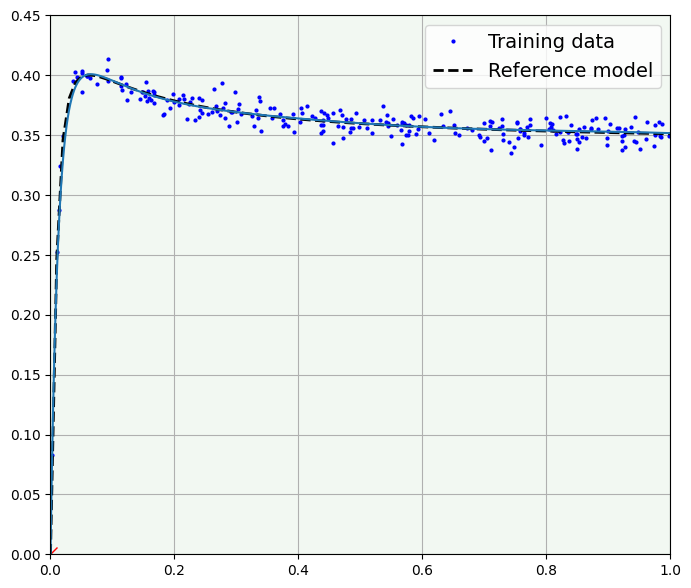

In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_k_mse is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
print(f"K-MSE: {best_k_mse}")
print(f"R2:    {best_r2}")
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree.compute_output(xp));
plt.show()


--- Pull from B(x) ---


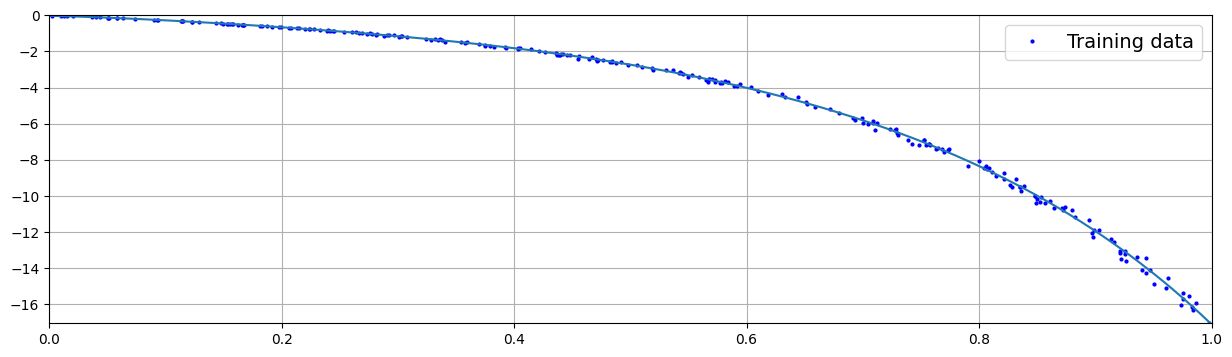

Model:
        6        5         4         3         2
-27.16 x + 65.8 x - 76.29 x + 34.58 x - 12.47 x - 1.559 x - 0.02635
Coeffs Softmax:
[0.11504207 0.22130604 0.08141394 0.17765412 0.12757802 0.13775569
 0.13925011]
Coeffs:
[-2.71609973e+01  6.57983564e+01 -7.62872945e+01  3.45809957e+01
 -1.24650396e+01 -1.55945189e+00 -2.63545153e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 16.181890465762866
R2:    0.5361995942590344


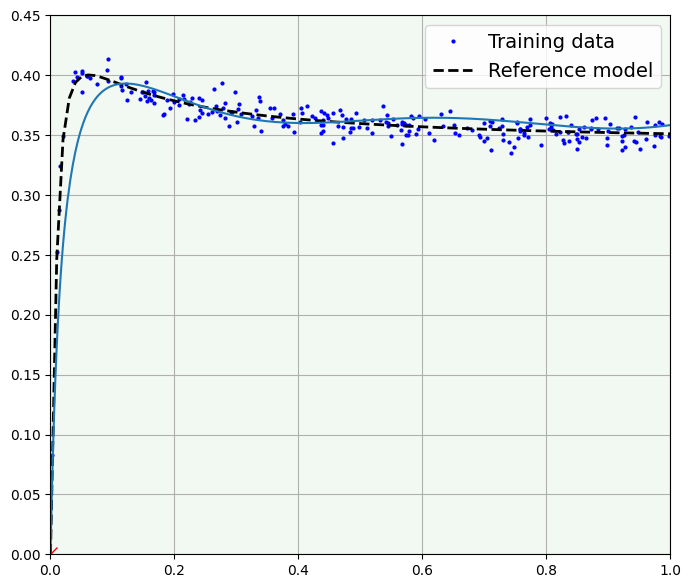



--- Pull from A(x) ---


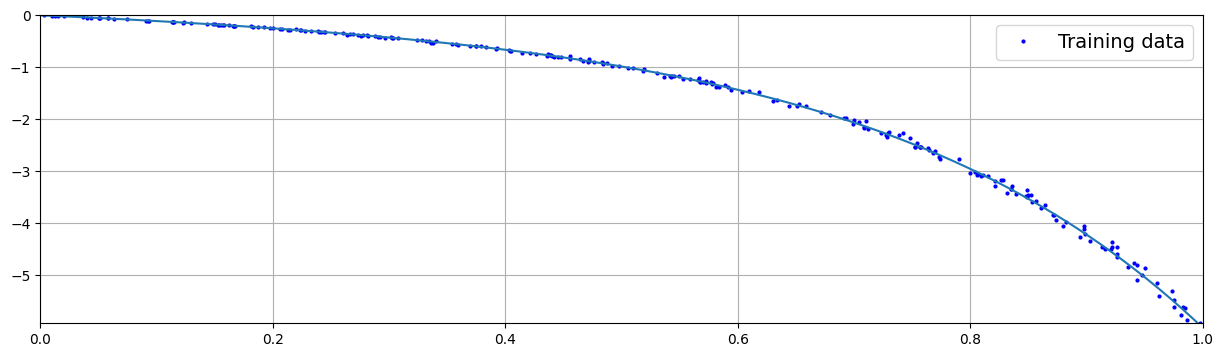

Model:
        6         5         4         3         2
-3.877 x + 6.657 x - 8.417 x + 2.166 x - 1.579 x - 0.9647 x
Coeffs Softmax:
[0.11216716 0.22559921 0.08299331 0.16747566 0.13063665 0.13606775
 0.14506026]
Coeffs:
[-3.87656623  6.65710075 -8.41748796  2.16604884 -1.57875298 -0.96471888
  0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 7.7855075076596325
R2:    0.8890364782592775


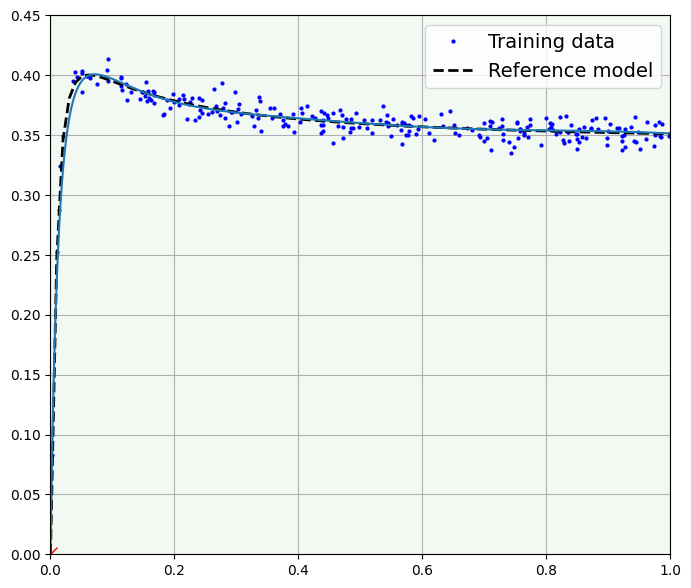



--- Pull from B(x) ---


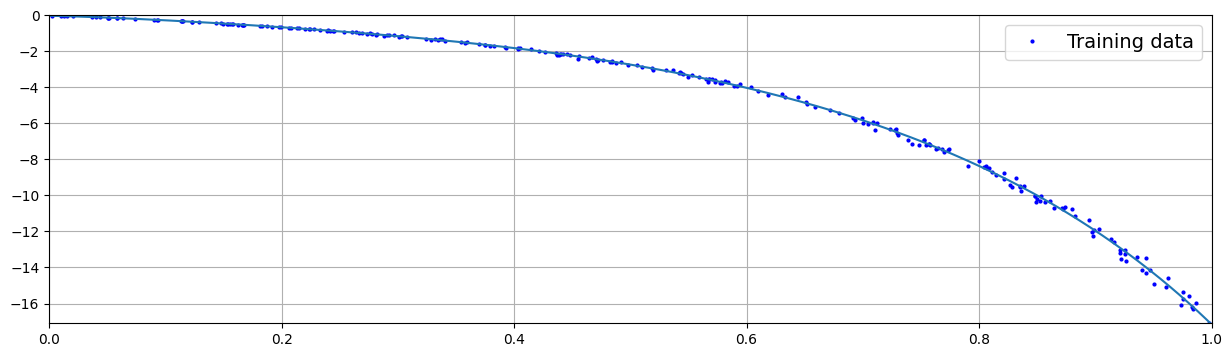

Model:
        6         5         4        3         2
-34.31 x + 84.69 x - 94.35 x + 42.1 x - 13.77 x - 1.491 x - 0.02559
Coeffs Softmax:
[0.11461071 0.22278922 0.08195957 0.17562109 0.12854587 0.13767106
 0.13880247]
Coeffs:
[-3.43138680e+01  8.46920796e+01 -9.43490826e+01  4.20986585e+01
 -1.37698721e+01 -1.49098486e+00 -2.55889321e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.700535387228977
R2:    0.9022126797886824


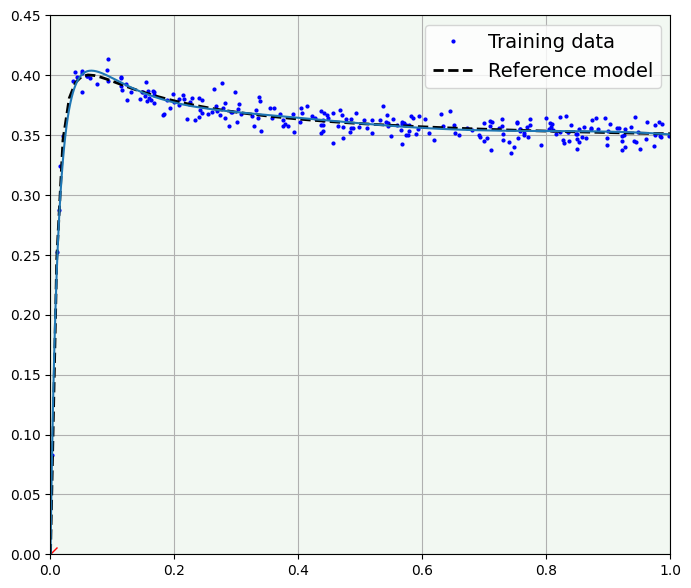



--- Pull from A(x) ---


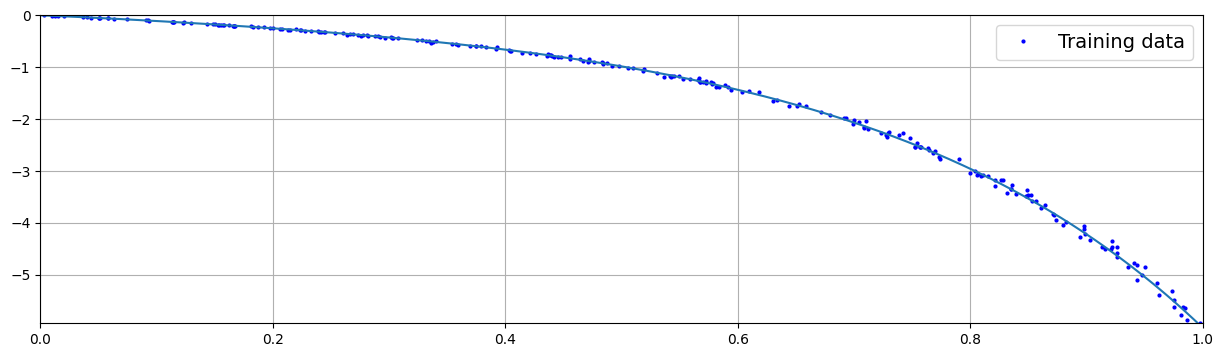

Model:
        6         5        4         3         2
-6.704 x + 14.18 x - 15.7 x + 5.272 x - 2.146 x - 0.9303 x
Coeffs Softmax:
[0.11269216 0.22667649 0.08338962 0.1682417  0.1312609  0.13670834
 0.14103079]
Coeffs:
[ -6.70382558  14.18194869 -15.70337114   5.27247162  -2.14550486
  -0.93028435   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 7.476528741339846
R2:    0.8902906849077759


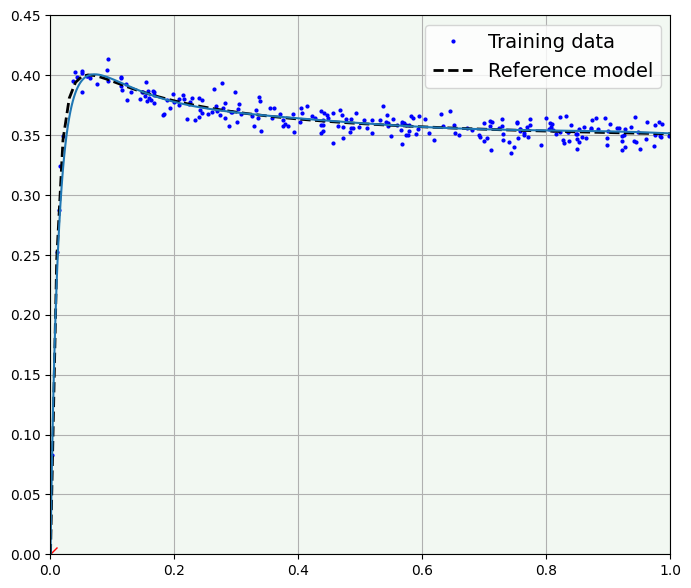



--- Pull from B(x) ---


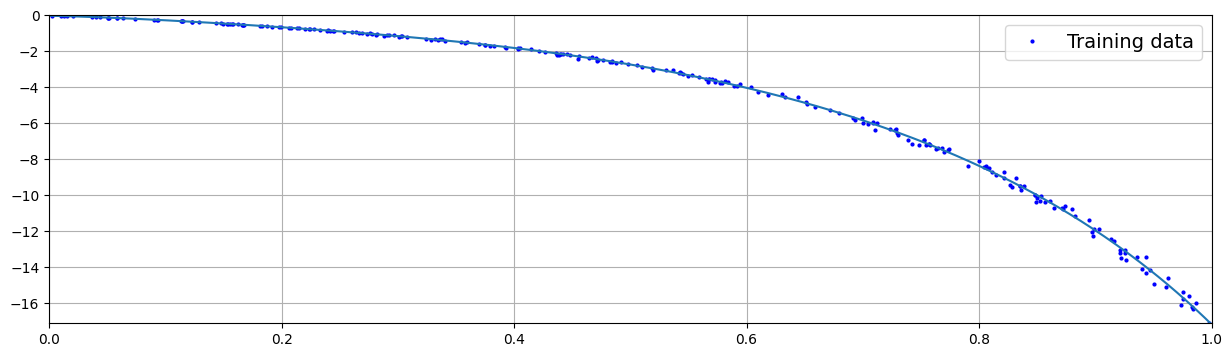

Model:
        6         5         4         3         2
-41.34 x + 103.3 x - 112.1 x + 49.47 x - 15.05 x - 1.424 x - 0.02484
Coeffs Softmax:
[0.11432813 0.22375479 0.08231479 0.17430308 0.12917681 0.13761256
 0.13850983]
Coeffs:
[-4.13410259e+01  1.03252251e+02 -1.12083551e+02  4.94710253e+01
 -1.50464984e+01 -1.42433108e+00 -2.48400848e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.36960052632348
R2:    0.9030638435410451


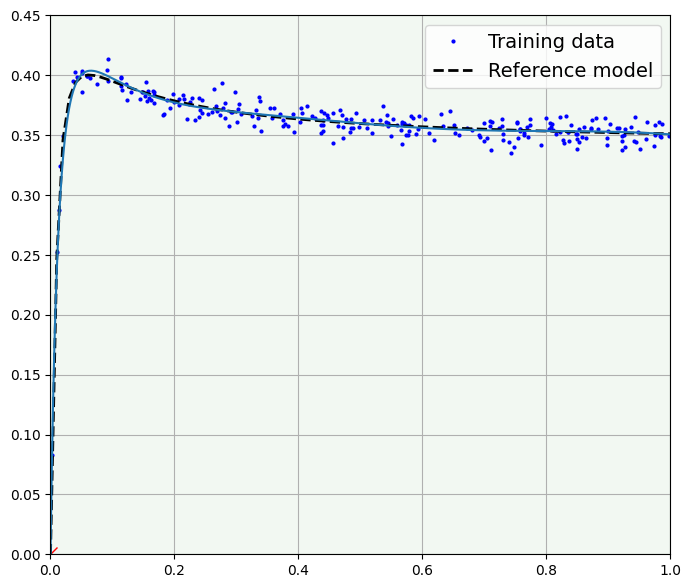



--- Pull from A(x) ---


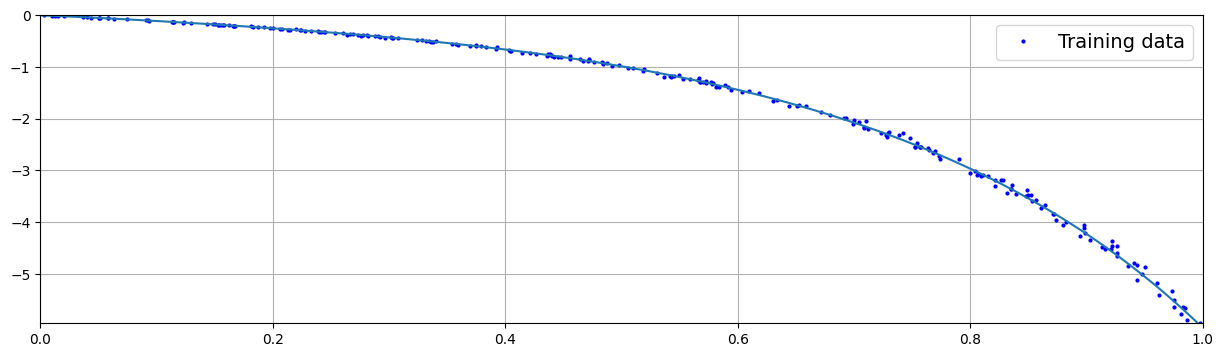

Model:
       6         5         4         3       2
-9.48 x + 21.57 x - 22.85 x + 8.318 x - 2.7 x - 0.8967 x
Coeffs Softmax:
[0.11286155 0.22703998 0.08352334 0.16847587 0.13147179 0.13691784
 0.13970963]
Coeffs:
[ -9.4804782   21.57098009 -22.85398044   8.31752205  -2.69987916
  -0.89672484   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 7.162170133178345
R2:    0.8915478523584013


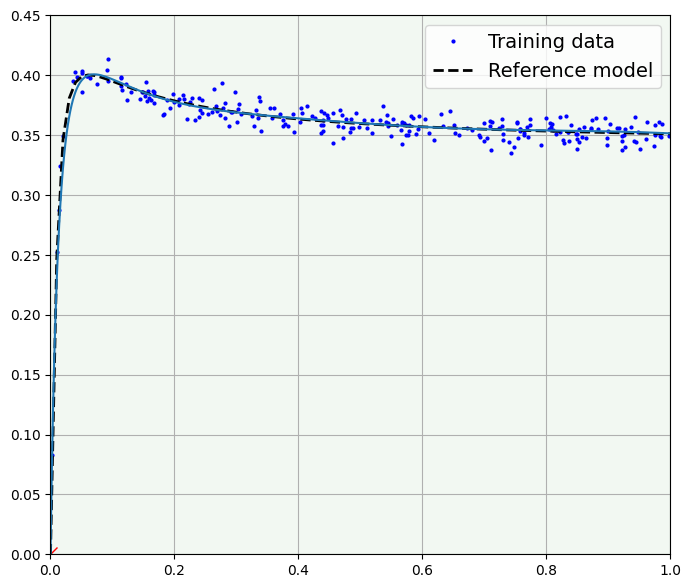



--- Pull from B(x) ---


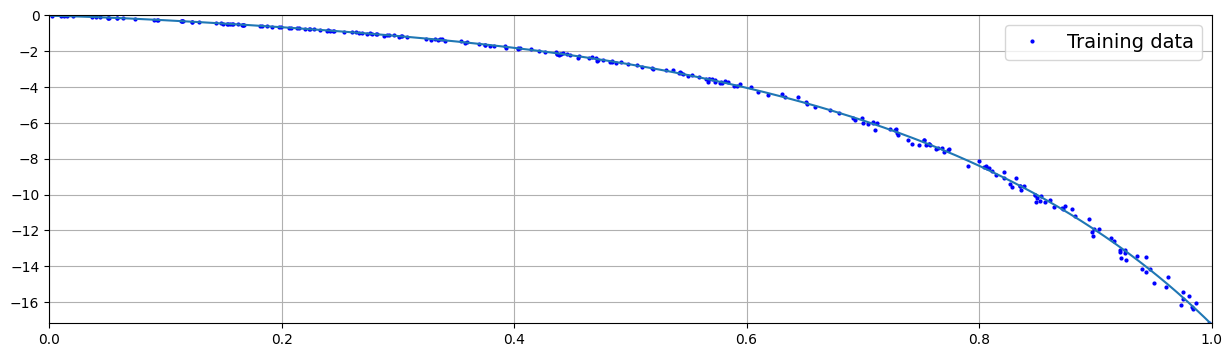

Model:
        6         5         4         3        2
-48.25 x + 121.5 x - 129.5 x + 56.71 x - 16.3 x - 1.359 x - 0.0241
Coeffs Softmax:
[0.11412816 0.22443577 0.0825653  0.17337537 0.12962227 0.13756968
 0.13830344]
Coeffs:
[-4.82531388e+01  1.21507242e+02 -1.29518254e+02  5.67098928e+01
 -1.62969493e+01 -1.35943761e+00 -2.40972689e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.030109782648808
R2:    0.9039641848042699


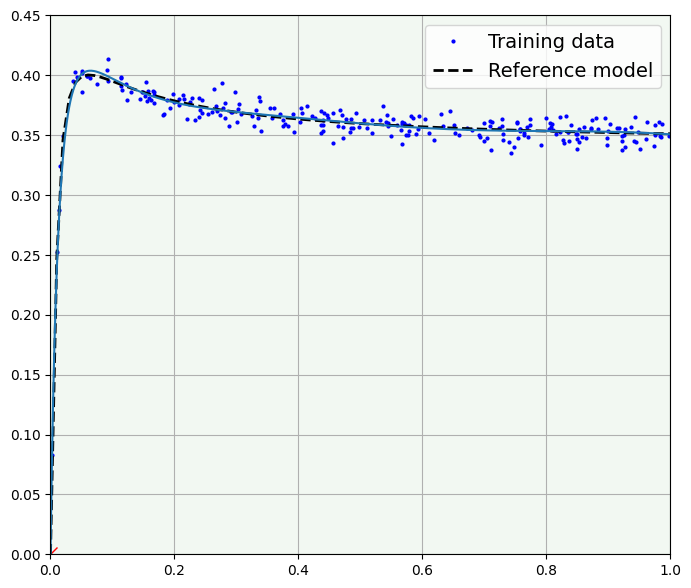



--- Pull from A(x) ---


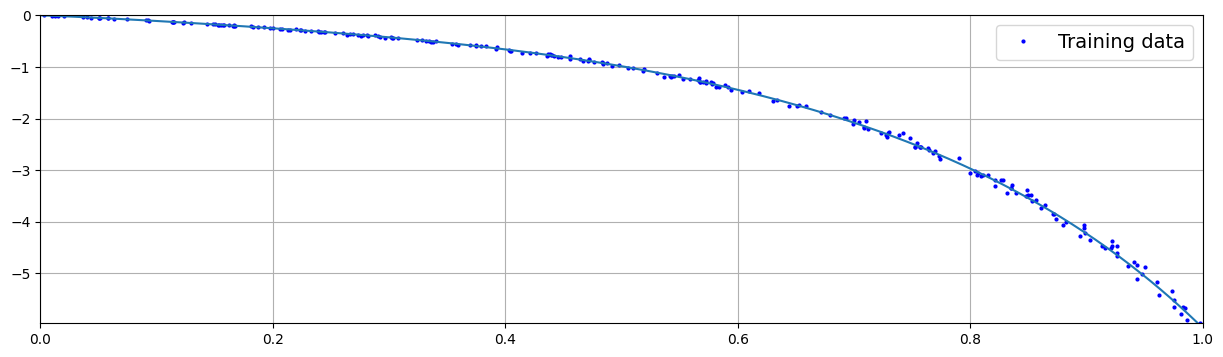

Model:
        6         5         4         3         2
-12.21 x + 28.84 x - 29.89 x + 11.31 x - 3.244 x - 0.8639 x
Coeffs Softmax:
[0.11294458 0.22722661 0.083592   0.16858253 0.13158042 0.13702182
 0.13905204]
Coeffs:
[-12.21411002  28.84499533 -29.89053697  11.31112327  -3.24396454
  -0.86388489   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.838324156375975
R2:    0.8928441059597538


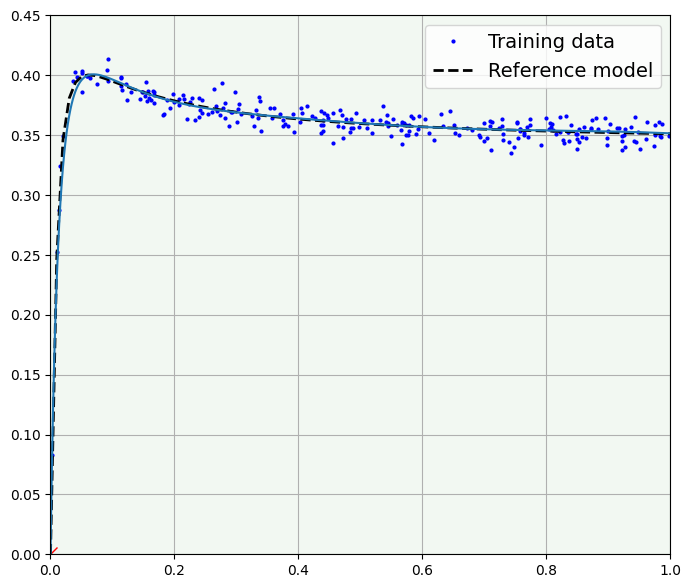



--- Pull from B(x) ---


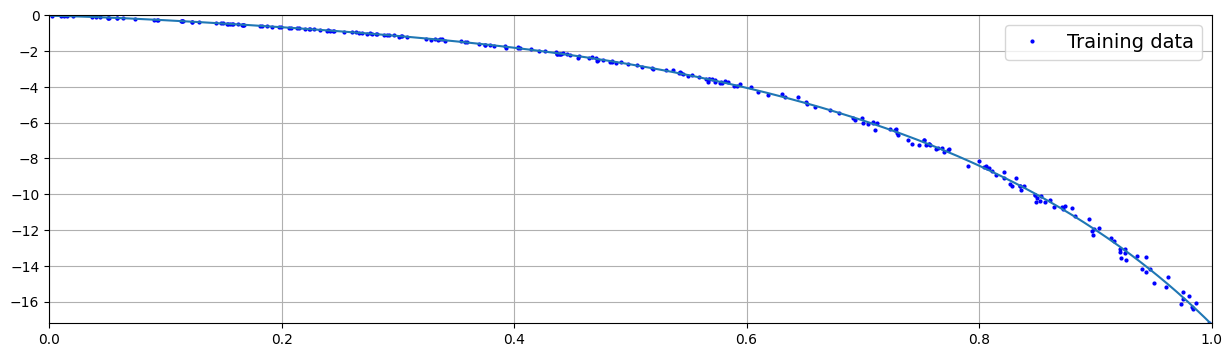

Model:
        6         5         4         3         2
-55.04 x + 139.4 x - 146.6 x + 63.81 x - 17.52 x - 1.296 x - 0.02338
Coeffs Softmax:
[0.11397925 0.22494222 0.08275162 0.17268582 0.12995381 0.13753699
 0.13815028]
Coeffs:
[-5.50432951e+01  1.39439467e+02 -1.46637300e+02  6.38094364e+01
 -1.75206949e+01 -1.29618368e+00 -2.33780776e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.6976364876730194
R2:    0.9047870286817776


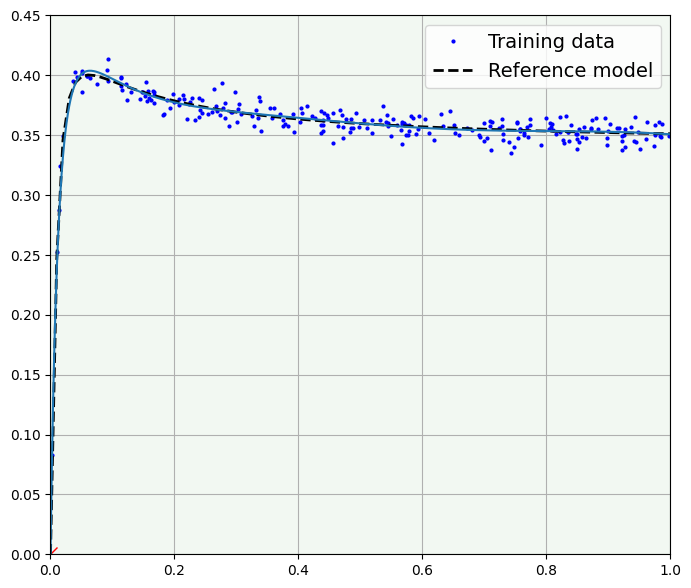



--- Pull from A(x) ---


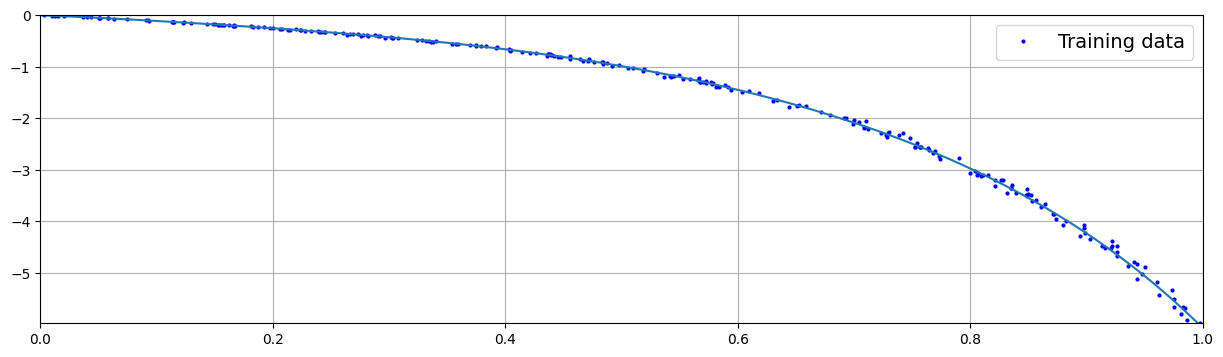

Model:
       6         5         4         3         2
-14.9 x + 35.98 x - 36.79 x + 14.24 x - 3.775 x - 0.8319 x
Coeffs Softmax:
[0.11299233 0.22734467 0.08363543 0.16863508 0.13164928 0.13708351
 0.13865969]
Coeffs:
[-14.89637476  35.98112338 -36.78966231  14.24229507  -3.77543466
  -0.83193852   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.515204479688116
R2:    0.8941091490769747


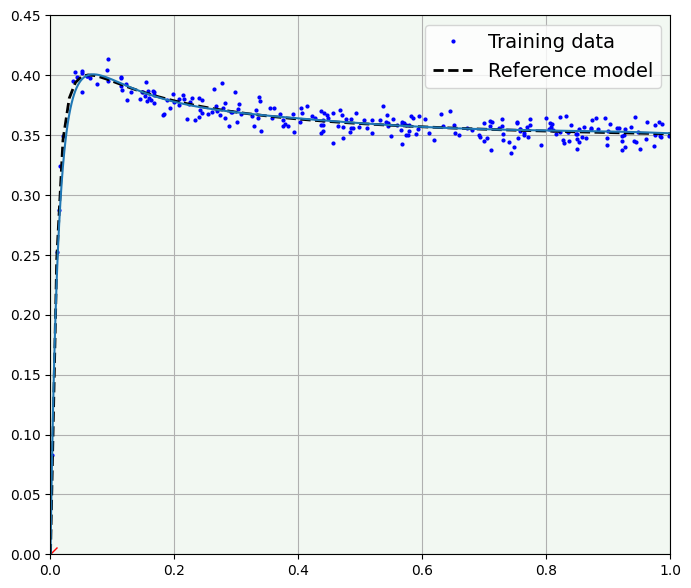



--- Pull from B(x) ---


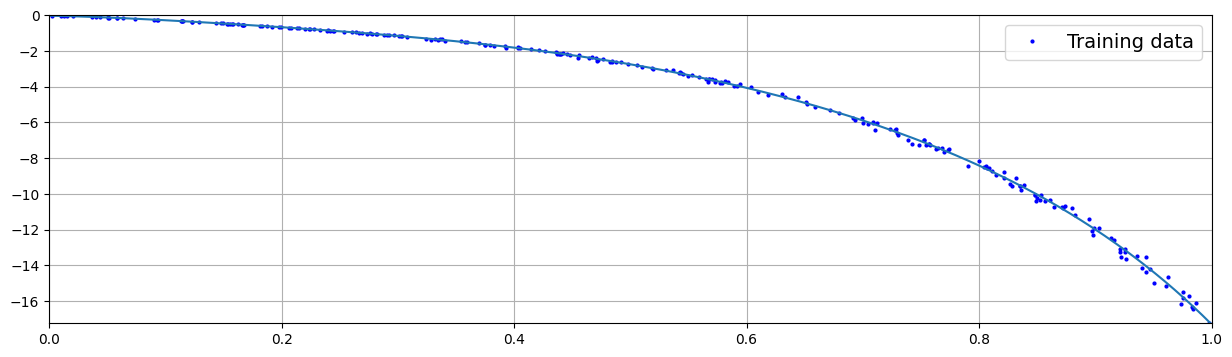

Model:
       6       5         4         3         2
-61.7 x + 157 x - 163.4 x + 70.76 x - 18.72 x - 1.235 x - 0.02268
Coeffs Softmax:
[0.11386377 0.22533479 0.08289604 0.17215099 0.13021088 0.13751121
 0.13803234]
Coeffs:
[-6.17043007e+01  1.57028884e+02 -1.63419603e+02  7.07592452e+01
 -1.87153063e+01 -1.23480108e+00 -2.26768569e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.367936084589136
R2:    0.9055871627431235


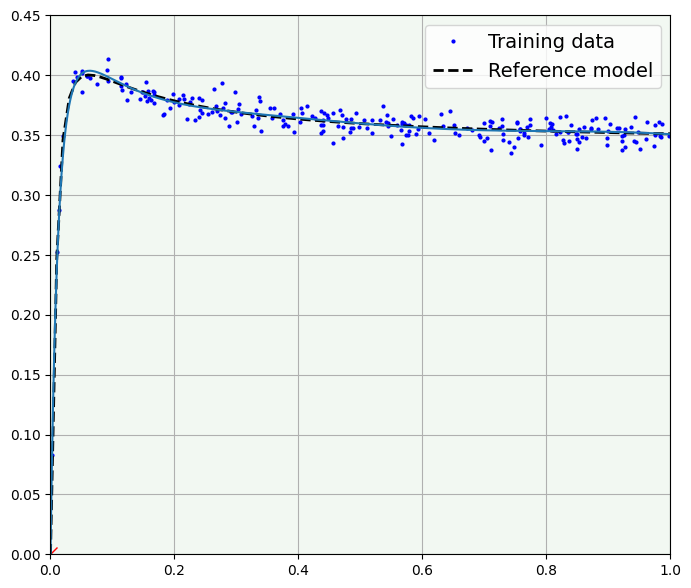



--- Pull from A(x) ---


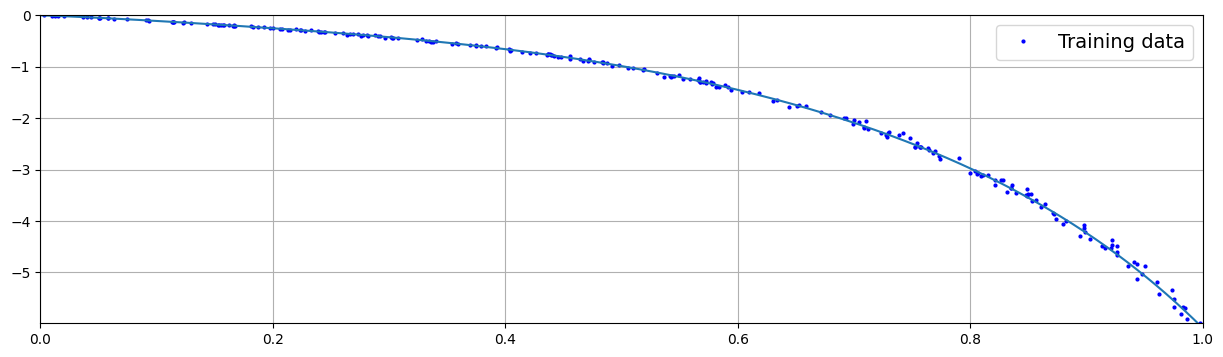

Model:
        6         5         4         3         2
-17.53 x + 42.98 x - 43.55 x + 17.11 x - 4.294 x - 0.8009 x
Coeffs Softmax:
[0.11302244 0.22742895 0.08366643 0.1686602  0.13169856 0.13712415
 0.13839927]
Coeffs:
[-17.52664904  42.97765911 -43.54958828  17.11018141  -4.29409988
  -0.80090049   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 6.190771388351993
R2:    0.8953680158845658


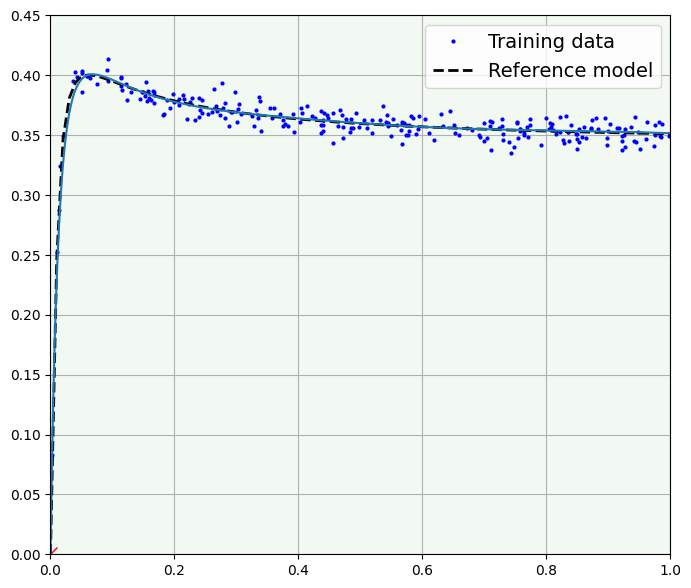



--- Pull from B(x) ---


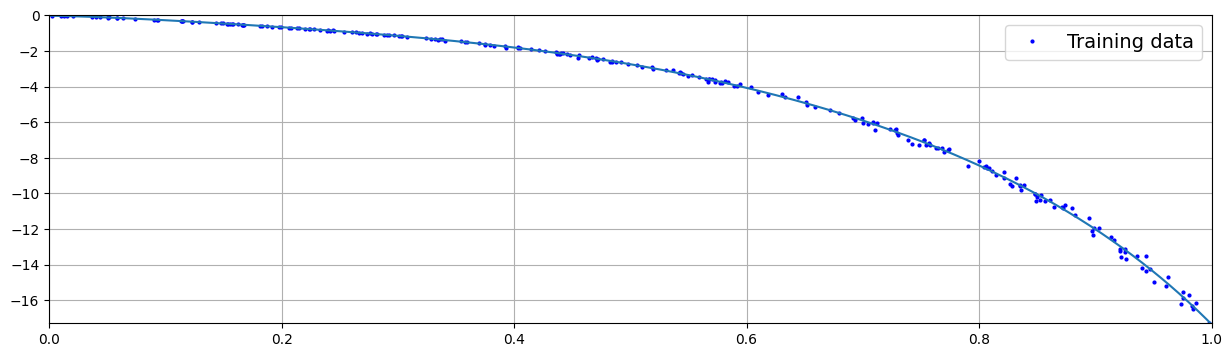

Model:
        6         5         4         3         2
-68.24 x + 174.3 x - 179.9 x + 77.56 x - 19.88 x - 1.175 x - 0.02199
Coeffs Softmax:
[0.1137714  0.22564891 0.0830116  0.17172237 0.13041661 0.13749031
 0.1379388 ]
Coeffs:
[-6.82351840e+01  1.74272880e+02 -1.79862495e+02  7.75580539e+01
 -1.98805179e+01 -1.17530590e+00 -2.19940969e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.04256217869743
R2:    0.9063626728582144


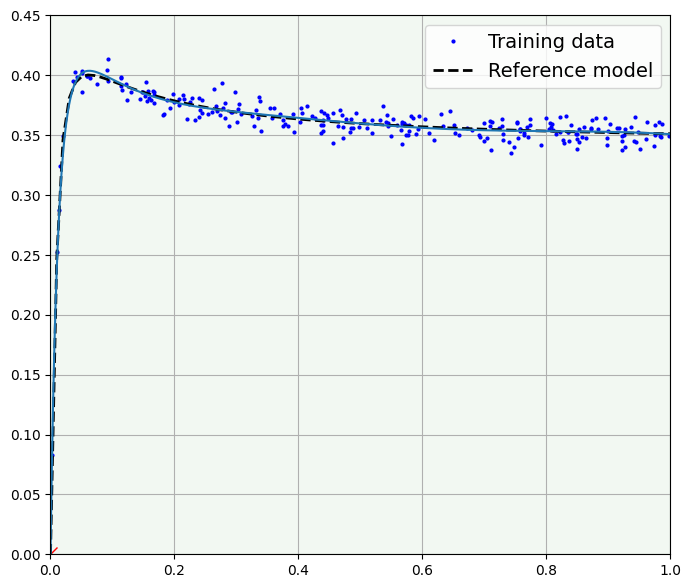



--- Pull from A(x) ---


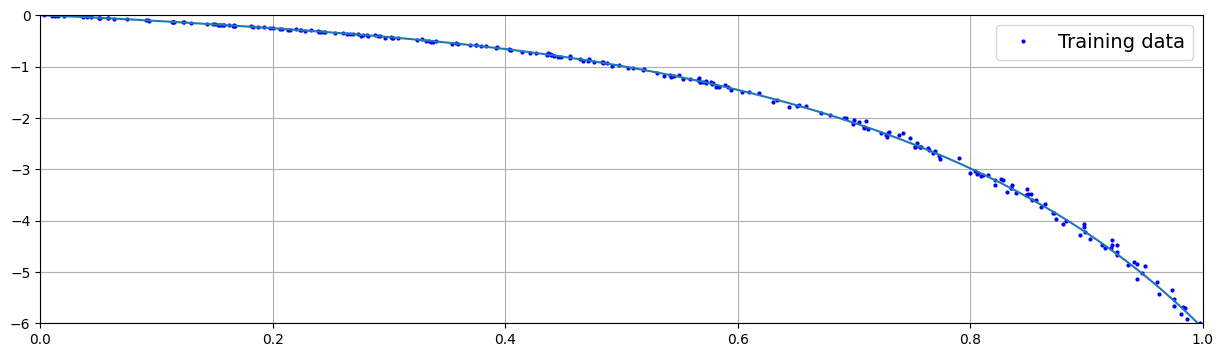

Model:
       6         5         4         3       2
-20.1 x + 49.83 x - 50.17 x + 19.91 x - 4.8 x - 0.7708 x
Coeffs Softmax:
[0.11304242 0.22749424 0.08369045 0.16866929 0.13173682 0.13715279
 0.13821399]
Coeffs:
[-20.10449202  49.83339762 -50.16905726  19.91416483  -4.79982055
  -0.77078193   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.866397640693611
R2:    0.8966166993512837


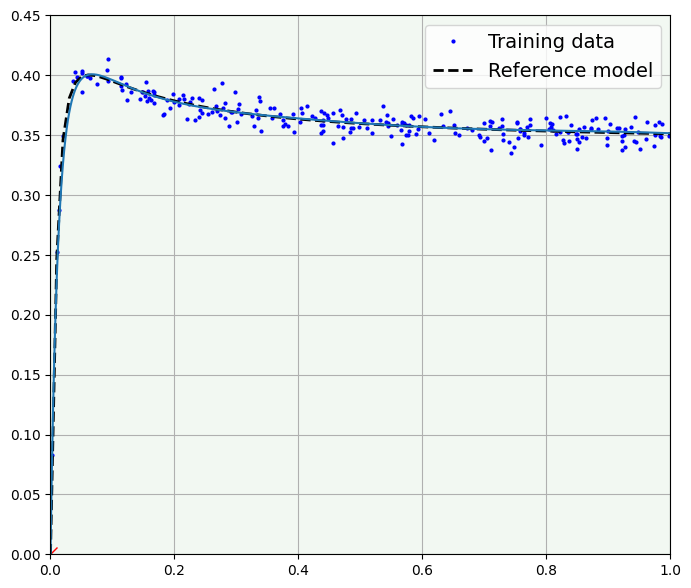



--- Pull from B(x) ---


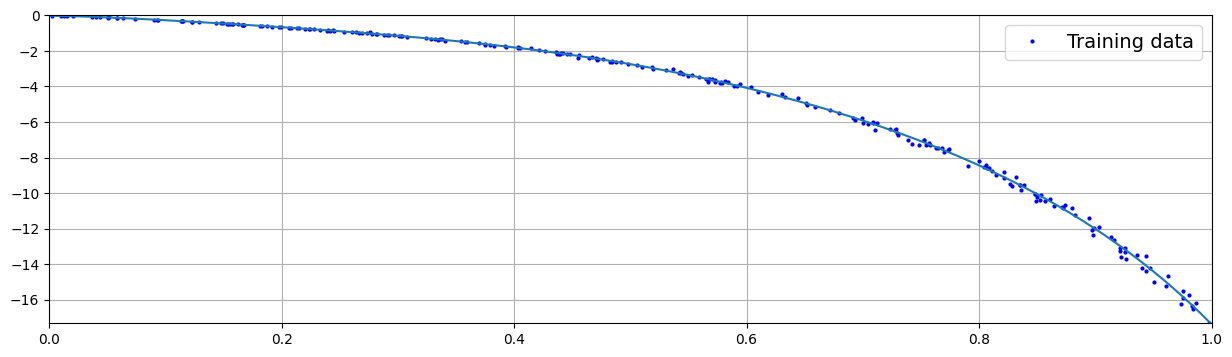

Model:
        6         5       4         3         2
-74.64 x + 191.2 x - 196 x + 84.21 x - 21.02 x - 1.118 x - 0.02133
Coeffs Softmax:
[0.11369564 0.22590682 0.08310648 0.17136968 0.13058552 0.137473
 0.13786286]
Coeffs:
[-7.46366659e+01  1.91173259e+02 -1.95967554e+02  8.42064360e+01
 -2.10164130e+01 -1.11769166e+00 -2.13303027e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 4.722918841230623
R2:    0.9071120081649813


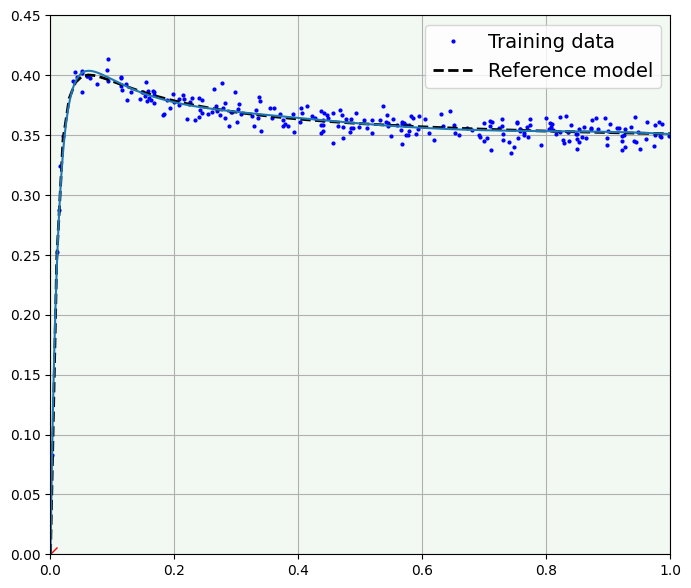



--- Pull from A(x) ---


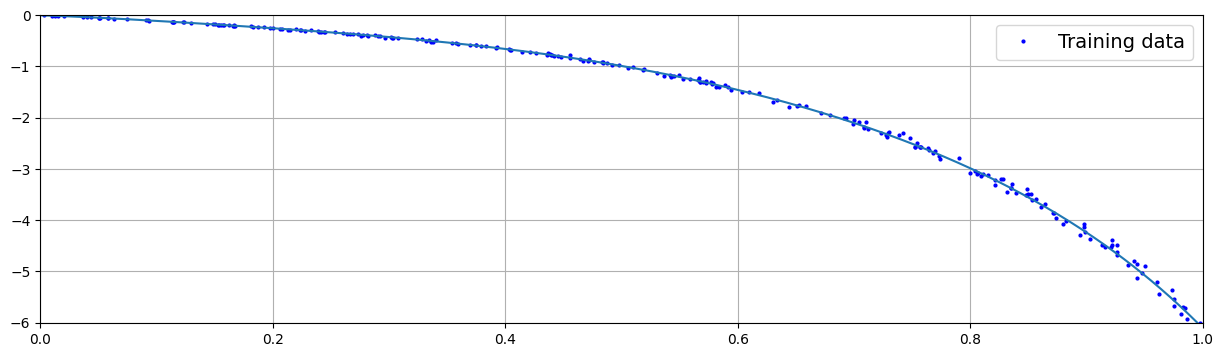

Model:
        6         5         4         3         2
-22.63 x + 56.55 x - 56.65 x + 22.65 x - 5.293 x - 0.7416 x
Coeffs Softmax:
[0.11305602 0.22754793 0.08371021 0.16866802 0.13176835 0.13717393
 0.13807554]
Coeffs:
[-22.63005278  56.5486774  -56.64829739  22.65427227  -5.29257959
  -0.74158607   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.5436333364255725
R2:    0.8978503510917387


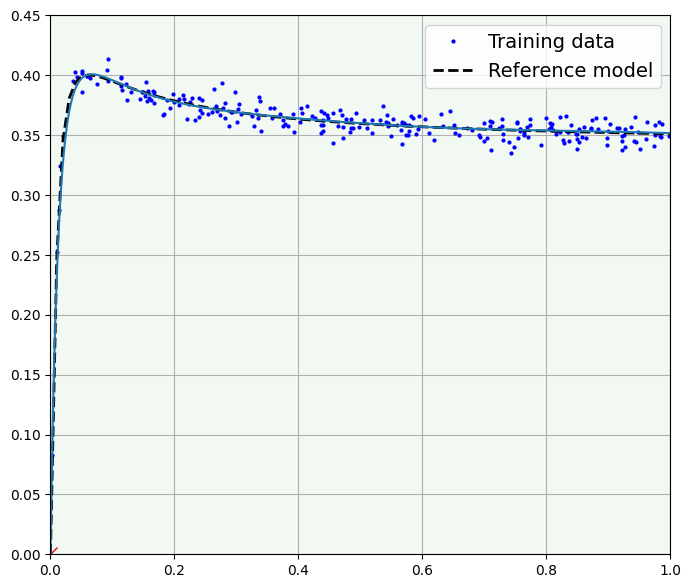



--- Pull from B(x) ---


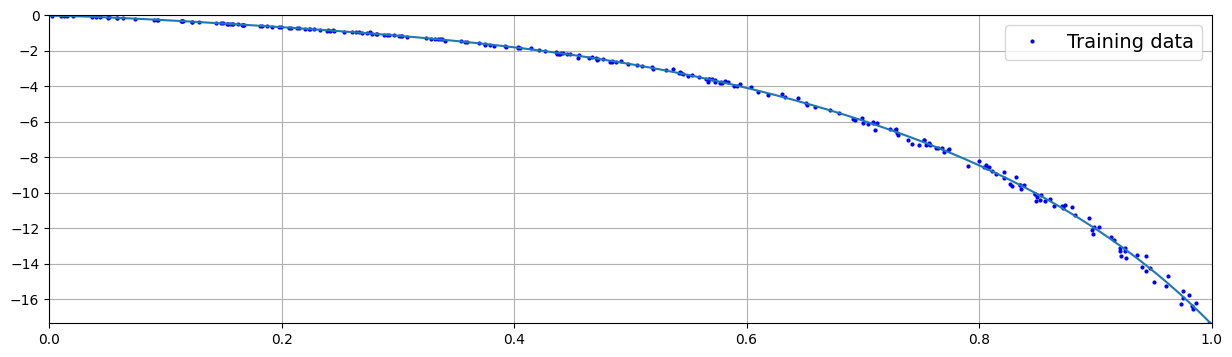

Model:
        6         5         4        3         2
-80.91 x + 207.7 x - 211.7 x + 90.7 x - 22.12 x - 1.062 x - 0.02069
Coeffs Softmax:
[0.11363225 0.22612303 0.08318601 0.17107316 0.1307271  0.13745839
 0.13780005]
Coeffs:
[-8.09074476e+01  2.07726638e+02 -2.11731470e+02  9.07028959e+01
 -2.21226867e+01 -1.06197919e+00 -2.06855334e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 4.41045568694833
R2:    0.9078325758166614


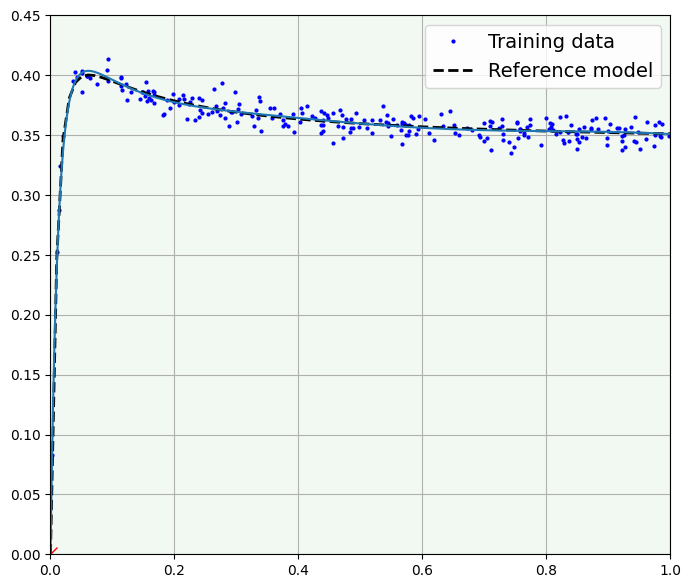



--- Pull from A(x) ---


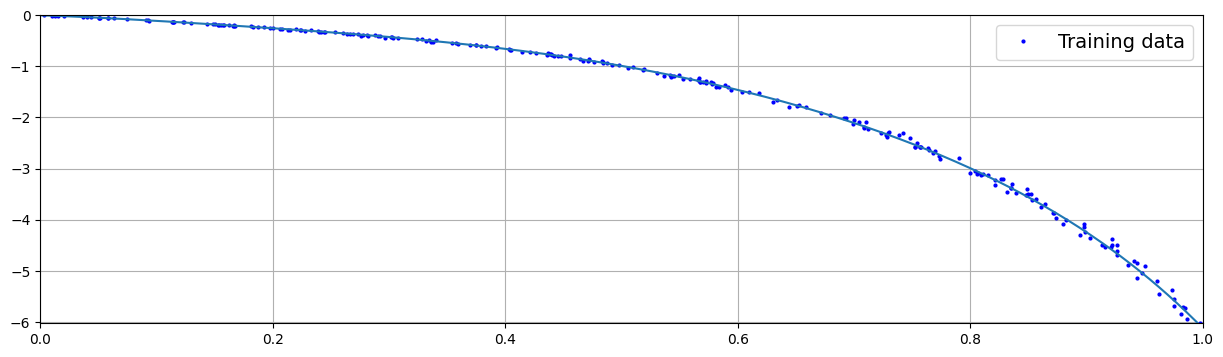

Model:
       6         5         4         3         2
-25.1 x + 63.12 x - 62.99 x + 25.33 x - 5.772 x - 0.7133 x
Coeffs Softmax:
[0.11306534 0.22759406 0.08372718 0.16865958 0.1317955  0.13719007
 0.13796827]
Coeffs:
[-25.10290249  63.1223852  -62.98621738  25.33000534  -5.77227265
  -0.71332061   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 5.2238430136478184
R2:    0.8990662379950656


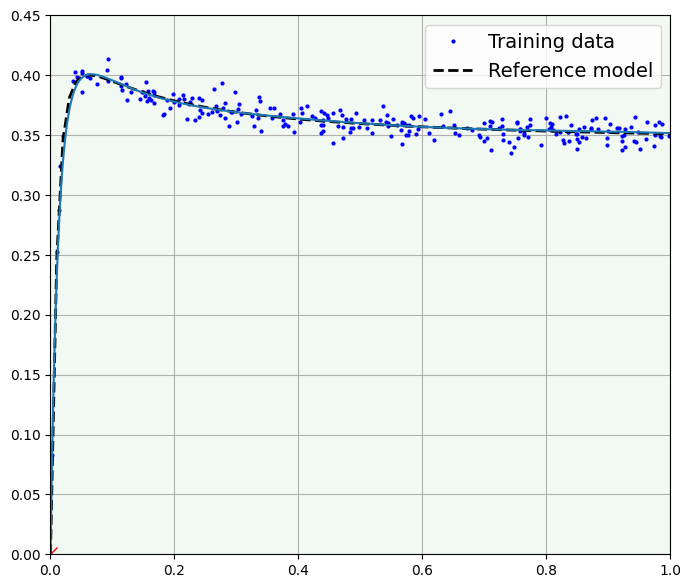



--- Pull from B(x) ---


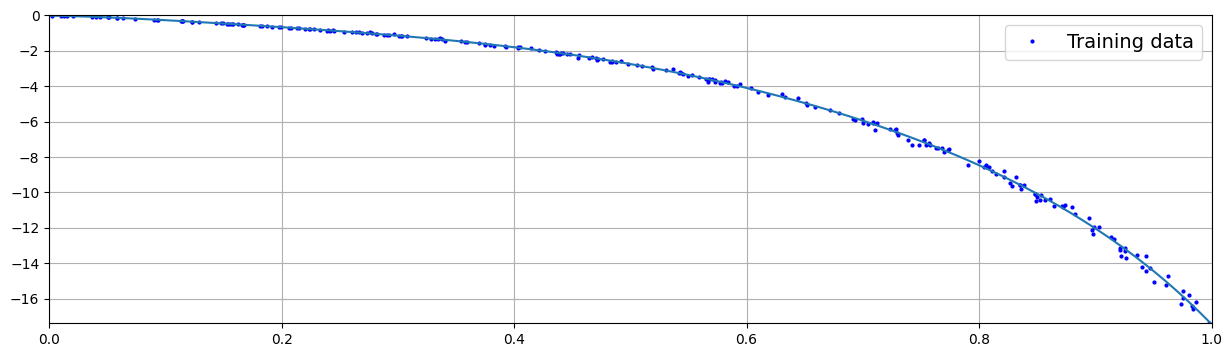

Model:
        6         5         4         3        2
-87.05 x + 223.9 x - 227.2 x + 97.05 x - 23.2 x - 1.008 x - 0.02006
Coeffs Softmax:
[0.1135783  0.2263075  0.08325388 0.1708193  0.13084787 0.13744587
 0.13774727]
Coeffs:
[-8.70481704e+01  2.23934767e+02 -2.27155962e+02  9.70481823e+01
 -2.31994849e+01 -1.00815581e+00 -2.00602083e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 4.106405323763361
R2:    0.9085226832661235


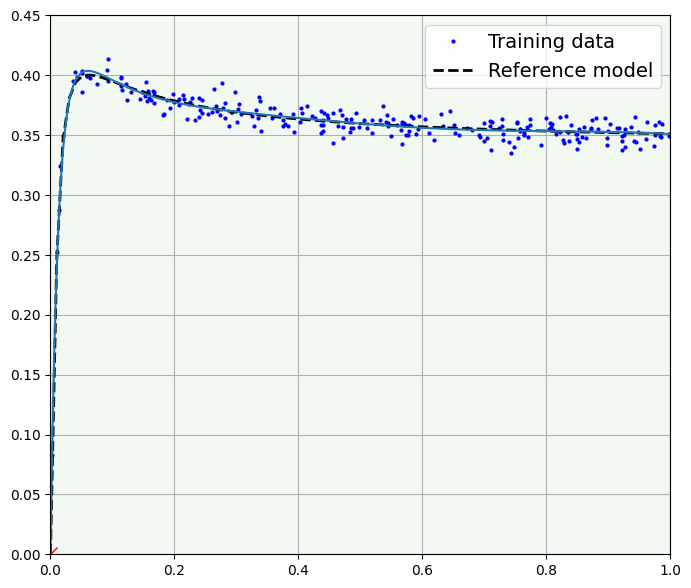



--- Pull from A(x) ---


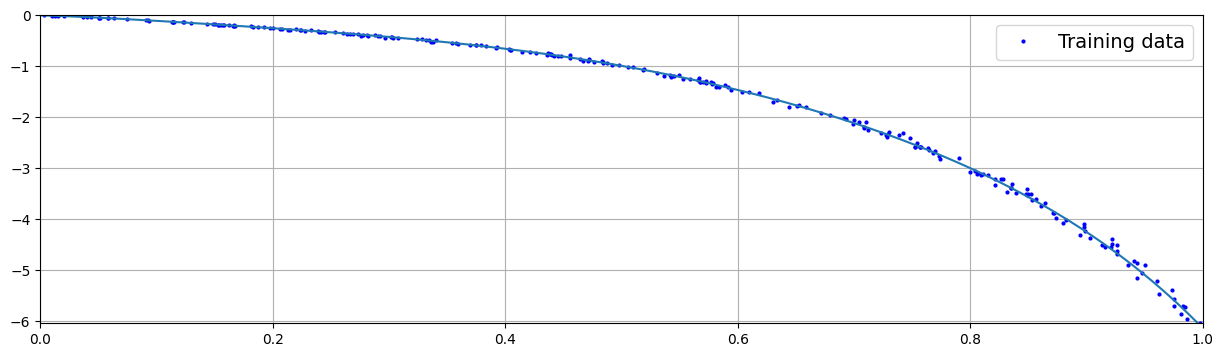

Model:
        6         5         4         3         2
-27.52 x + 69.55 x - 69.18 x + 27.94 x - 6.239 x - 0.686 x
Coeffs Softmax:
[0.11307164 0.22763503 0.08374225 0.16864592 0.13181968 0.13720271
 0.13788278]
Coeffs:
[-27.52317434  69.55487877 -69.18314345  27.94148153  -6.23891291
  -0.68598561   0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 4.908577869099152
R2:    0.9002592224561501


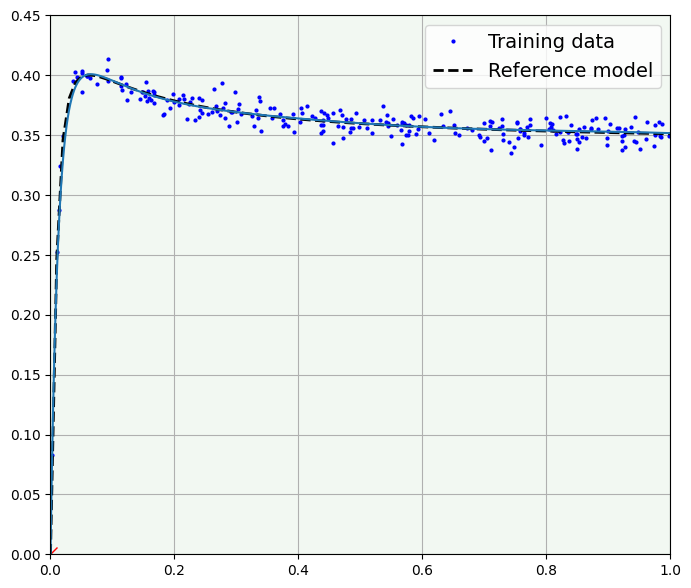

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if len(hist_entry.pulled_S.data) > 0:
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")
        print(f"Coeffs:\n{model.c}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = "{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    _, r2, k_mse = S.evaluate(stree.compute_output)
    print(f"K-MSE: {k_mse}")
    print(f"R2:    {r2}")
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()